# Analysis of prediction using 3x3 blocks of Test images

This notebook serves as a visulization of misclassified examples in the pretrained model.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
from keras.models import load_model
from vis.visualization import visualize_saliency
model = None

Using TensorFlow backend.


# Using saved model to directly predict on train set

## Load and preprocess training images

In [3]:
master = pd.read_csv("../input/train_labels.csv")
img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' )
    y.append(master.iloc[i,1])
y = np.array(y)

### Preprocessing images pipeline

In [4]:
#image resize & centering & crop in 9x9 blocks
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [9]:
def preproess_image(i):
    file_path = file_paths[i-1]
    sys.stdout.write("\r Preprocess image from {0} / total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ll, ww = img.shape[0]//3, img.shape[1]//3
    sub_images = []
    for i in range(3):
        for j in range(3):
            sub_img = img[i*ll:(i+1)*ll, j*ww:(j+1)*ww, :]

            #resize
            if(sub_img.shape[0] > sub_img.shape[1]):
                tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
            else:
                tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

            #centering
            sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
            #output 224*224px 
            sub_img = sub_img[16:240, 16:240]
            sub_img = sub_img.astype('float32')
            sub_img /= 255.0
            sub_images.append(sub_img)
    return np.array(sub_images)

## Load saved model `VGG16-transferlearning.model`

In [6]:
if not model:
    model = load_model('VGG16-transferlearning.model')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
from vis.utils import utils
layer_idx = utils.find_layer_idx(model, 'dense_2')

## Saliency map

In [33]:
from vis.visualization import overlay
import matplotlib.gridspec as gridspec
def saliency_map_view(i):
    # model prediction
    test_images = preproess_image(i)
    y_pred = model.predict(test_images)
    # saliency map
    saliency_map = []
    for img in test_images:
        smap = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=img, 
                                  backprop_modifier='guided', grad_modifier='relu')
        saliency_map.append(smap)
    saliency_map = np.array(saliency_map)
    
    
    fig = plt.figure(figsize=(18, 6))
    outer = gridspec.GridSpec(1, 3)

    for i, images in enumerate([test_images, saliency_map, overlay(test_images, saliency_map)]):
        inner = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[i])

        for j in range(9):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(images[j]);ax.set_title('{0} / {1:.6f}'.format(j+1, float(y_pred[j]))); ax.axis('off')
            fig.add_subplot(ax)

### Helps with false negatives because of zooming in feature

 Preprocess image from ../input/train/304.jpg / total 2295 images

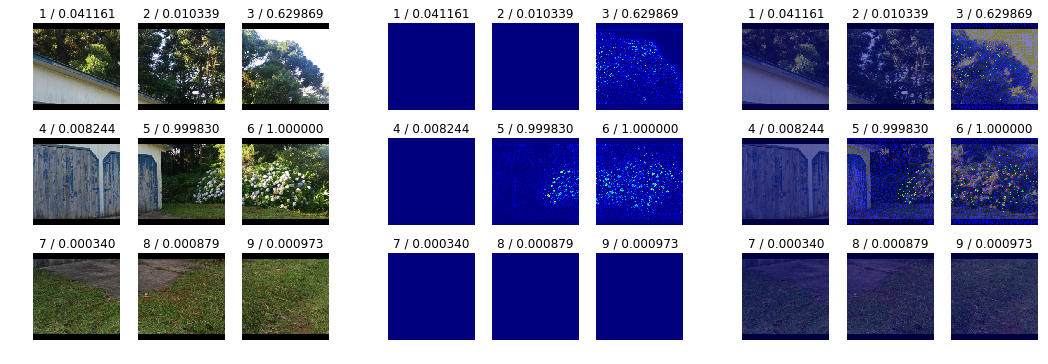

In [36]:
saliency_map_view(i=304)

 Preprocess image from ../input/train/313.jpg / total 2295 images

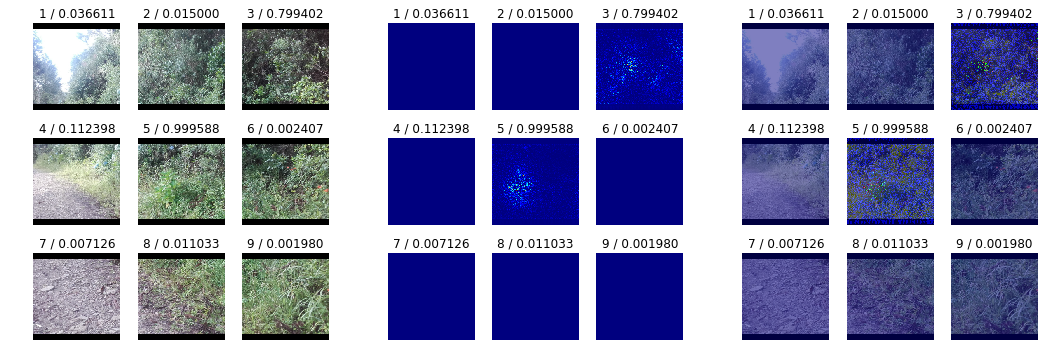

In [38]:
saliency_map_view(i=313)

### Does not help with false positives

 Preprocess image from ../input/train/403.jpg / total 2295 images

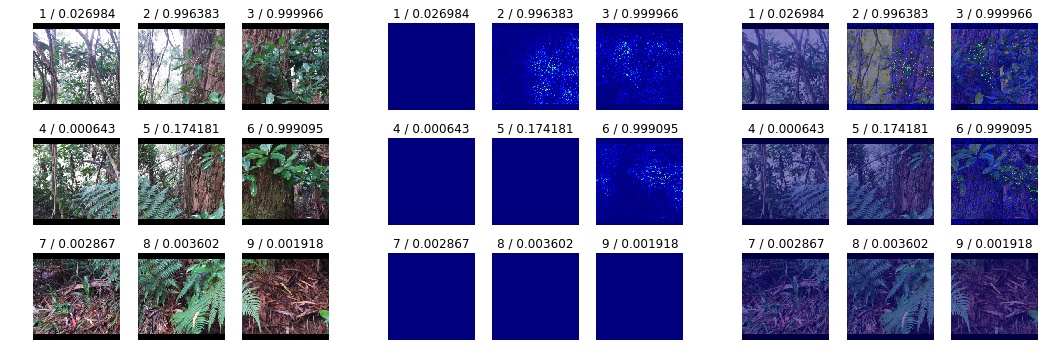

In [39]:
saliency_map_view(i=403)

 Preprocess image from ../input/train/1598.jpg / total 2295 images

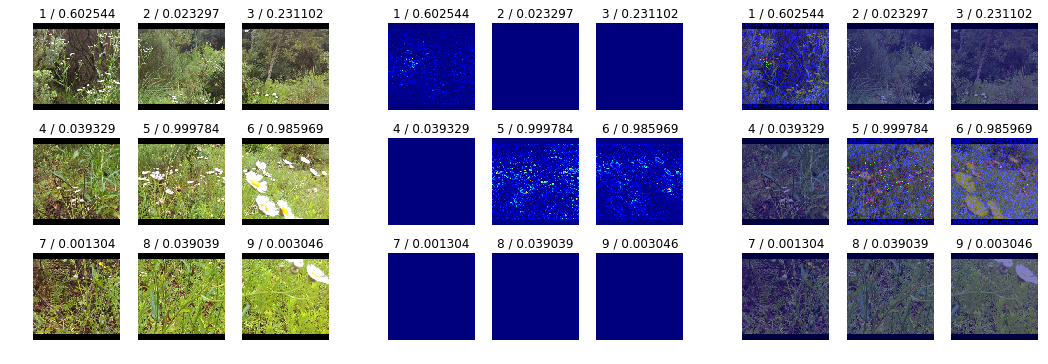

In [41]:
saliency_map_view(i=1598)

### Can potentially further increase the possibility of false positives

 Preprocess image from ../input/train/231.jpg / total 2295 images

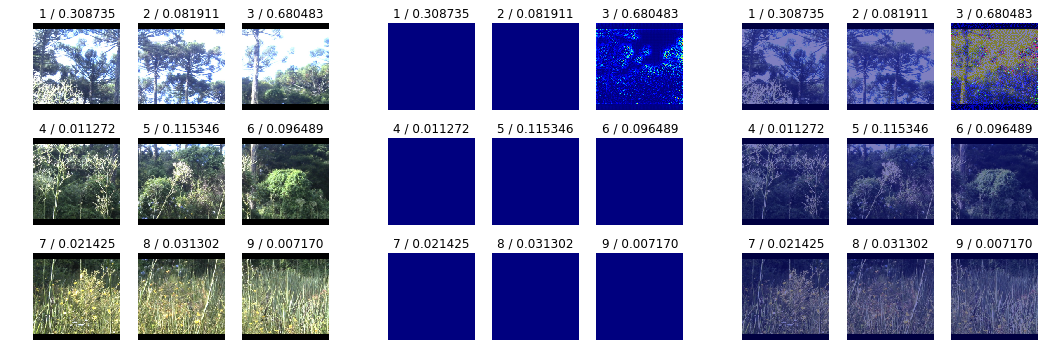

In [42]:
saliency_map_view(i=231)

## Conclusion

- One may consider split the images into 9x9 blocks in the test phase, and give the prediction probability as the max of all nine predictions. But it turns out there is a very high probability that will leads to much higher false positive rate, thus potentially harm the performance.
- Onw may also consider a mild case, that is cut the images in to 4x4 blocks, plus a center block of the same size. It turns out this still leads to increased false postive.
- In the next notebook, I will try two other approaches:
    - The first one is to use [left, middle, right] half of the whole image + the whole image. The average score of the four gives the final prediction.
    - The other approach is too use several center-cropped images with various sizes. The final prediction will be the average of two highest scores.